In [ ]:
import sys
#!{sys.executable} -m pip install fancyimpute 
#!{sys.executable} -m pip install tqdm 
!{sys.executable} -m conda update numpy

In [1]:
from fancyimpute import IterativeImputer

Using TensorFlow backend.


In [2]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import keras
from time import time
#from tensorflow.python.keras.callbacks import TensorBoard


In [3]:
dataset1 = pd.read_excel("Punjabi_bagh_2016.xlsx")
dataset2 = pd.read_excel("Punjabi_bagh_2017.xlsx")
dataset3 = pd.read_excel("Punjabi_bagh_2018.xlsx")
dataset4 = pd.read_excel("Punjabi_bagh_2019.xlsx")

In [4]:
dataset4 = dataset4.drop([4050, 4051, 4052, 4053, 4054, 4055])
dataset4.tail()

,From Date,To Date,BP,NO2,Ozone,PM10,PM2.5,AT,CO,NO,RH,SO2,SR,VWS,WD,WS
4045,18-06-2019 13:00,18-06-2019 14:00,734.19,21.48,54.5,59.75,None,30.77,0.62,3.07,36.53,8.62,120.8,0.15,89,2.02
4046,18-06-2019 14:00,18-06-2019 15:00,734.31,16.48,60.3,74.75,36,30.55,0.6,2.42,34.27,7.1,186.98,0,85,1.3
4047,18-06-2019 15:00,18-06-2019 16:00,734.25,19.88,62.97,59,36,29.77,0.67,2.6,0.9,11.4,156.38,0.1,78.5,1.12
4048,18-06-2019 16:00,18-06-2019 17:00,734.17,22.95,60.73,60.25,None,28.98,0.67,2.23,0.9,9.2,104.75,0.08,87.5,0.95
4049,18-06-2019 17:00,18-06-2019 17:54,734.03,21.15,63,64,None,28.52,0.77,1.95,0.9,10.38,72.33,0.08,69.5,1.27


In [5]:
print(len(dataset1)+len(dataset2)+len(dataset3)+len(dataset4))

30365


In [6]:
frames = [dataset1, dataset2, dataset3, dataset4]
result_date_index = pd.concat(frames, sort = True)
result_date_index = result_date_index.set_index(["To Date"])
result_date_index = result_date_index.drop(['Temp', 'THC', 'VWS', 'From Date'], axis=1)
#result_date_index.index = pd.to_datetime(result_date_index.index, dayfirst=True)

In [7]:
result_date_index.head()

,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,SO2,SR,WD,WS
To Date,,,,,,,,,,,,,
01-01-2016 01:00,10.22,738,0.34,72.91,99.96,11.85,528.33,334,67.33,21.33,15,153.08,0.43
01-01-2016 02:00,9.37,738,0.47,94.07,86.74,11.23,528.67,354,70.83,26.85,14.92,145.92,0.3
01-01-2016 03:00,9.22,738,0.58,82.03,87.12,12.07,663.4,354,71.92,26.84,14.58,158.83,0.46
01-01-2016 04:00,8.96,738,1.03,48.89,84.37,11.44,619.67,354,72.33,26.66,14.75,150.25,0.3
01-01-2016 05:00,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350,73.33,16.59,14.75,146.25,0.31


In [8]:
#Do this befor adding date and time, cause else it makes it also nans
result = result_date_index.replace("None", np.nan)
result = result.replace(0, np.nan)
result = result.reset_index()
result = result.drop("To Date", axis = 1)

In [9]:
#Making the -ve values to Nan
for j in range(len(result.columns)): 
    df1 = result[result.columns[j]]
    for i in range(len(df1)):
        if df1.values[i] <  0:
            df1.values[i] = np.nan
    result.values[:, j] = df1.values
result.isnull().values.any()
result.head()

,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,SO2,SR,WD,WS
0,10.22,738.00,0.34,72.91,99.96,11.85,528.33,334.0,67.33,21.33,15.00,153.08,0.43
1,9.37,738.00,0.47,94.07,86.74,11.23,528.67,354.0,70.83,26.85,14.92,145.92,0.30
2,9.22,738.00,0.58,82.03,87.12,12.07,663.40,354.0,71.92,26.84,14.58,158.83,0.46
3,8.96,738.00,1.03,48.89,84.37,11.44,619.67,354.0,72.33,26.66,14.75,150.25,0.30
4,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350.0,73.33,16.59,14.75,146.25,0.31


In [10]:
#Take values in dataset_1 of those parameters which needs to be imputed
#dataset_1 = result[["NO2", "Ozone", "PM10", "PM2.5", "SO2", "NO", "CO", "AT", "BP", 'SR', "WD", "WS", "RH"  ]]
dataset_1 = result

In [11]:
print(dataset_1.isnull().values.any())
dataset_1.head()

True


,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,SO2,SR,WD,WS
0,10.22,738.00,0.34,72.91,99.96,11.85,528.33,334.0,67.33,21.33,15.00,153.08,0.43
1,9.37,738.00,0.47,94.07,86.74,11.23,528.67,354.0,70.83,26.85,14.92,145.92,0.30
2,9.22,738.00,0.58,82.03,87.12,12.07,663.40,354.0,71.92,26.84,14.58,158.83,0.46
3,8.96,738.00,1.03,48.89,84.37,11.44,619.67,354.0,72.33,26.66,14.75,150.25,0.30
4,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350.0,73.33,16.59,14.75,146.25,0.31


In [12]:
#Interpolate the Nan Values here else are dropped in the series_to_supervised function

#from fancyimpute import IterativeImputer
XY_incomplete = dataset_1.values[:, :]

n_imputations = 10
XY_completed = []
for i in range(n_imputations):
    imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
    XY_completed.append(imputer.fit_transform(XY_incomplete))

XY_completed_mean = np.mean(XY_completed, 0)
XY_completed_std = np.std(XY_completed, 0)

#Save the imputed values in dataset_2
dataset_2 = pd.DataFrame(XY_completed_mean)
dataset_2.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,10.22,738.00,0.34,72.91,99.96,11.85,528.33,334.0,67.33,21.33,15.00,153.08,0.43
1,9.37,738.00,0.47,94.07,86.74,11.23,528.67,354.0,70.83,26.85,14.92,145.92,0.30
2,9.22,738.00,0.58,82.03,87.12,12.07,663.40,354.0,71.92,26.84,14.58,158.83,0.46
3,8.96,738.00,1.03,48.89,84.37,11.44,619.67,354.0,72.33,26.66,14.75,150.25,0.30
4,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350.0,73.33,16.59,14.75,146.25,0.31


In [13]:
np.shape(result.values)

(30365, 13)

In [14]:
#Revert back to previous indicies
#result.values[:,:] = dataset_2.values[:,:]
print(dataset_2.isnull().values.any())
dataset_3 = dataset_2

False


In [15]:
dataset_3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,10.22,738.00,0.34,72.91,99.96,11.85,528.33,334.0,67.33,21.33,15.00,153.08,0.43
1,9.37,738.00,0.47,94.07,86.74,11.23,528.67,354.0,70.83,26.85,14.92,145.92,0.30
2,9.22,738.00,0.58,82.03,87.12,12.07,663.40,354.0,71.92,26.84,14.58,158.83,0.46
3,8.96,738.00,1.03,48.89,84.37,11.44,619.67,354.0,72.33,26.66,14.75,150.25,0.30
4,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350.0,73.33,16.59,14.75,146.25,0.31


In [16]:
#Making the -ve values to Nan
for j in range(len(dataset_3.columns)): 
    df1 = dataset_3[j]
    for i in range(len(df1)):
        if df1.values[i] <  0:
            df1.values[i] = np.nan
    dataset_3.values[:, j] = df1.values
#["NO2", "Ozone", "PM10", "PM2.5", "SO2", "NO", "CO", "AT", "BP", 'SR', "WD", "WS", "RH"  ]
dataset_3.isnull().values.any()

True

In [17]:
dataset_3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,10.22,738.00,0.34,72.91,99.96,11.85,528.33,334.0,67.33,21.33,15.00,153.08,0.43
1,9.37,738.00,0.47,94.07,86.74,11.23,528.67,354.0,70.83,26.85,14.92,145.92,0.30
2,9.22,738.00,0.58,82.03,87.12,12.07,663.40,354.0,71.92,26.84,14.58,158.83,0.46
3,8.96,738.00,1.03,48.89,84.37,11.44,619.67,354.0,72.33,26.66,14.75,150.25,0.30
4,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350.0,73.33,16.59,14.75,146.25,0.31


In [18]:
#Now impute these Nan Values(placed in location of -ve values) with either knn or linear, etc.
dataset_3_further_interpolated = dataset_3.interpolate(method ='nearest') 
#dataset_3_further_interpolated.plot(marker = '.',figsize = (20,20))
dataset_3_further_interpolated.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,10.22,738.00,0.34,72.91,99.96,11.85,528.33,334.0,67.33,21.33,15.00,153.08,0.43
1,9.37,738.00,0.47,94.07,86.74,11.23,528.67,354.0,70.83,26.85,14.92,145.92,0.30
2,9.22,738.00,0.58,82.03,87.12,12.07,663.40,354.0,71.92,26.84,14.58,158.83,0.46
3,8.96,738.00,1.03,48.89,84.37,11.44,619.67,354.0,72.33,26.66,14.75,150.25,0.30
4,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350.0,73.33,16.59,14.75,146.25,0.31


In [ ]:
#############################################################################

In [ ]:
final_result = pd.DataFrame(index=result.index, columns= result.columns)
final_result.values[:, :] = dataset_2.values[:, :]
final_result.tail()

In [ ]:
#plt.hlines(0, 0, 27000, colors='k', linestyles='solid')

dataset_3_further_interpolated_with_indexes.plot(marker = '.',figsize = (20,20))

In [ ]:
#plt.hlines(0, 0, 27000, colors='k', linestyles='solid')

final_result.plot(marker = '.',figsize = (40,40))
#result[0].plot(marker = '*',figsize = (20,20))

In [ ]:
final_result_linear = result.interpolate(method ='linear', limit_direction ='forward') 
final_result_linear.plot(marker = '.',figsize = (20,20))
final_result_linear.isnull().values.any()

In [ ]:
final_result_nearest = result.interpolate(method ='nearest') 
final_result_nearest.plot(marker = '.',figsize = (20,20))
final_result_nearest.isnull().values.any()

In [ ]:
final_result_slinear = result.interpolate(method ='slinear') 
final_result_slinear.plot(marker = '.',figsize = (20,20))
final_result_slinear.isnull().values.any()

In [ ]:
final_result_nearest.head()

In [ ]:
dataset_3_further_interpolated_with_indexes.to_csv("H:\Celestini 2019\Dataset\punjabibagh-60\Punjabi_bagh_dataset_3_further_interpolated_with_indexes.csv")   

In [ ]:
dataset.head()

In [ ]:
"""import matplotlib.mlab as mlab
from sklearn.neighbors import KernelDensity

# Generate random samples from a mixture of 2 Gaussians
# with modes at 5 and 10
# Plot the true distribution
x = np.linspace(0, 400, 1000)[:, np.newaxis]
norm_vals = mlab.normpdf(x, 5, 1) * 0.25 + mlab.normpdf(x, 10, 1) * 0.75
plt.plot(x, norm_vals)

# Plot the data using a normalized histogram
plt.hist(df[0], 50)

# Do kernel density estimation
kd = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(df[[0]])

# Plot the estimated densty
kd_vals = np.exp(kd.score_samples(x))
plt.plot(x, kd_vals)

# Show the plots
plt.show()"""

In [ ]:
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from pandas import concat

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
dataset.head()

In [ ]:
dataset_3_further_interpolated_with_indexes = pd.read_csv("H:\Celestini 2019\Dataset\punjabibagh-60\Punjabi_bagh_dataset_3_further_interpolated_with_indexes.csv")   

In [ ]:
#change the dataframe here to use to it convert into supervised
dataset = dataset_3_further_interpolated_with_indexes.set_index(["From Date"])

In [ ]:
values = dataset.values
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_in=1, n_out=1, dropnan=True)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[23,24,26,28,31,32,34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]], axis=1, inplace=True)
print(reframed.head())

In [ ]:
# split into train and test sets
values = reframed.values
n_train_hours = 1000 * 24


train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-5], train[:, -5:]
test_X, test_y = test[:, :-5], test[:, -5:]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

In [ ]:
train_X.shape[1], train_X.shape[2]


In [ ]:
import keras
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from matplotlib import pyplot

model = Sequential()
model.add(LSTM(units = 5, input_shape=(train_X.shape[1], train_X.shape[2]), activation = 'tanh', recurrent_activation = 'hard_sigmoid', kernel_initializer= 'he_normal'))
model.add(Dense(5))
model.compile(optimizer='adam', loss='mae')

# fit network
history = model.fit(train_X, train_y, epochs = 50, batch_size=24, validation_data=(test_X, test_y), callbacks=[keras.callbacks.TensorBoard(log_dir='./logs{}'.format(time()), histogram_freq=5)])

#plot loss and val_loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
from keras import Sequential
from keras.layers import Dense,Dropout,LSTM,BatchNormalization
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(128,input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, activation='tanh', kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128,input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(5))

model.compile(loss='mean_squared_error',optimizer='adam')

history = model.fit(train_X,train_y,epochs=30,batch_size=24,shuffle=False,
                validation_data=(test_X,test_y), callbacks=[keras.callbacks.TensorBoard(log_dir='./logs_dropout_batchnorm{}'.format(time()))])

In [ ]:
model.evaluate(x=test_X, y=test_y, batch_size=None, verbose=1) 

In [ ]:
y_hat = model.predict(test_X, batch_size=None, verbose=0, steps=None)

In [ ]:
print(y_hat.shape)
print(test_X.shape)

In [ ]:
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))

In [ ]:
from numpy import concatenate
inv_yhat = np.concatenate((y_hat, test_X[:, 5:]),  axis = 1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0:5]

In [ ]:
test_y = test_y.reshape((len(test_y), 5))
inv_y = concatenate((test_y, test_X[:, 5:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0:5]

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
##################Quantile losss ###########################
dataset_3_further_interpolated_with_indexes = pd.read_csv("H:\Celestini 2019\Dataset\punjabibagh-60\Punjabi_bagh_dataset_3_further_interpolated_with_indexes.csv")   
#dataset = dataset_3_further_interpolated_with_indexes.set_index(["To Date"])
#dataset.index = pd.to_datetime(dataset_3_further_interpolated_with_indexes["To Date"], dayfirst= True )
#dataset.head()

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import re
import datetime
import tqdm

from keras.models import *
from keras.layers import *
from keras.layers.core import Lambda
from keras import backend as K

In [20]:
#dataset_3_further_interpolated["timestamp"] = result_date_index.index
#If want to insert timestamp at beginning coloumn 
timestamp = result_date_index.index  
dataset_3_further_interpolated.insert(loc = 0, column = "timestamp", value = timestamp)

In [21]:
dataset_3_further_interpolated.head()

,timestamp,0,1,2,3,4,5,6,7,8,9,10,11,12
0,01-01-2016 01:00,10.22,738.00,0.34,72.91,99.96,11.85,528.33,334.0,67.33,21.33,15.00,153.08,0.43
1,01-01-2016 02:00,9.37,738.00,0.47,94.07,86.74,11.23,528.67,354.0,70.83,26.85,14.92,145.92,0.30
2,01-01-2016 03:00,9.22,738.00,0.58,82.03,87.12,12.07,663.40,354.0,71.92,26.84,14.58,158.83,0.46
3,01-01-2016 04:00,8.96,738.00,1.03,48.89,84.37,11.44,619.67,354.0,72.33,26.66,14.75,150.25,0.30
4,01-01-2016 05:00,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350.0,73.33,16.59,14.75,146.25,0.31


0.1176427898241991


<IPython.core.display.Javascript object>


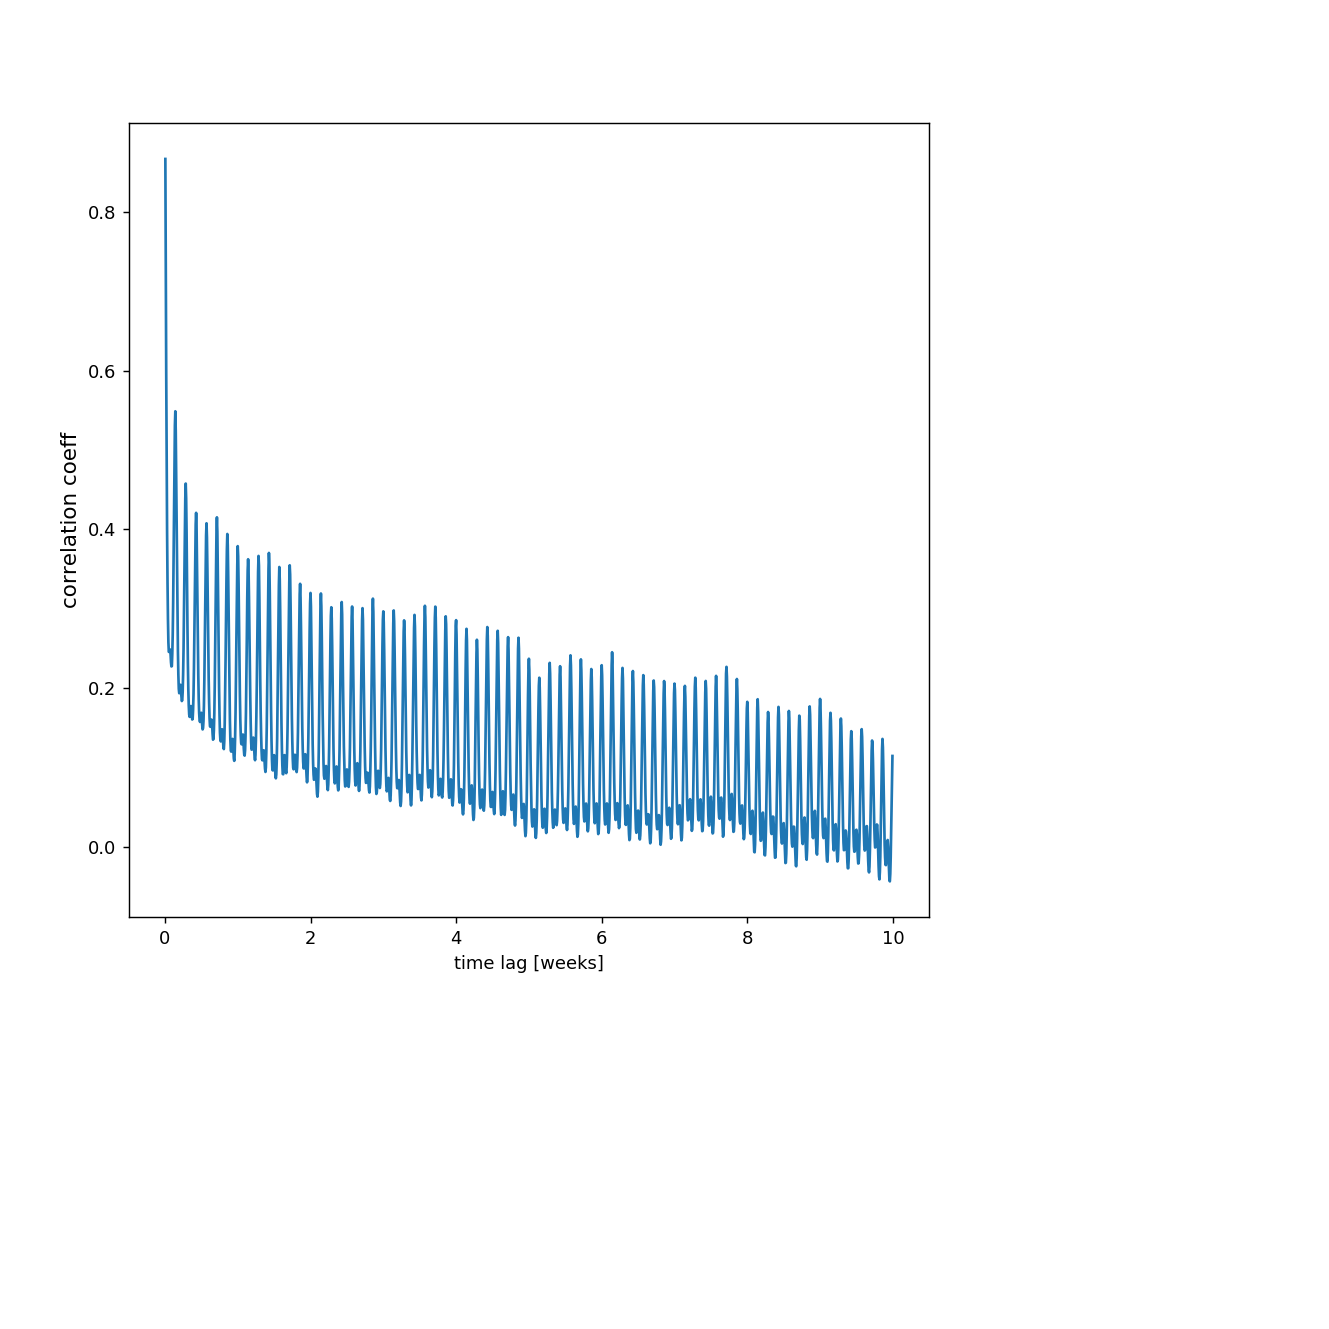

In [22]:
### WEEKLY AUTOCORR PLOT (10 WEEKS DEPTH) ###
timeLags = np.arange(1,10*24*7)
autoCorr = [dataset_3_further_interpolated[2].autocorr(lag=dt) for dt in timeLags]
print(np.mean(autoCorr))
plt.figure(figsize=(8,8))
plt.plot(1.0/(24*7)*timeLags, autoCorr);
plt.xlabel('time lag [weeks]'); plt.ylabel('correlation coeff', fontsize=12);

In [23]:
date = pd.DataFrame(np.vstack(dataset_3_further_interpolated.timestamp.apply(lambda x: re.sub(r':|-' ,' ', x).split()))[:,:4].astype(int))

dataset_3_further_interpolated = pd.concat([dataset_3_further_interpolated, date], axis=1)
dataset_3_further_interpolated.columns = ['timestamp', 'AT', 'BP', 'CO', 'NO', 'NO2', 'Ozone', 'PM10', 'PM2.5', 'RH', 'SO2', 'SR', 'WD', 'WS', 'd', 'mt', 'yr', 'H']

In [24]:
dataset_3_further_interpolated.tail()

,timestamp,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,SO2,SR,WD,WS,d,mt,yr,H
30360,18-06-2019 14:00,30.77,734.19,0.62,3.07,21.48,54.50,59.75,5.0,36.53,8.62,120.80,89.0,2.02,18,6,2019,14
30361,18-06-2019 15:00,30.55,734.31,0.60,2.42,16.48,60.30,74.75,36.0,34.27,7.10,186.98,85.0,1.30,18,6,2019,15
30362,18-06-2019 16:00,29.77,734.25,0.67,2.60,19.88,62.97,59.00,36.0,0.90,11.40,156.38,78.5,1.12,18,6,2019,16
30363,18-06-2019 17:00,28.98,734.17,0.67,2.23,22.95,60.73,60.25,NaN,0.90,9.20,104.75,87.5,0.95,18,6,2019,17
30364,18-06-2019 17:54,28.52,734.03,0.77,1.95,21.15,63.00,64.00,NaN,0.90,10.38,72.33,69.5,1.27,18,6,2019,17


In [25]:
### CREATE WEEKDAY FEATURE AND COMPUTE THE MEAN FOR WEEKDAYS AT EVERY HOURS ###
weekday = dataset_3_further_interpolated[['yr', 'mt', 'd']].apply(lambda x: datetime.datetime(x['yr'], x['mt'], x['d']).weekday(),axis=1).values
# weekend = weekday.copy()
# weekend[np.logical_and(weekend != 5, weekend != 6)] = 0
# weekend[weekend != 0] = 1

#Computed means for 22000 obs. Hence the train set will be 22000

dataset_3_further_interpolated['weekday'] = weekday
dataset_3_further_interpolated['weekday_hour'] = dataset_3_further_interpolated.weekday.astype(str) +' '+ dataset_3_further_interpolated.H.astype(str)
dataset_3_further_interpolated['m_weekday_CO'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['CO'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_NO2'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['NO2'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_PM10'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['PM10'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_PM2.5'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['PM2.5'].mean().to_dict())
dataset_3_further_interpolated['m_weekday_SO2'] = dataset_3_further_interpolated.weekday_hour.replace(dataset_3_further_interpolated[:22000].groupby('weekday_hour')['SO2'].mean().to_dict())

In [26]:
dataset_3_further_interpolated.head()

,timestamp,AT,BP,CO,NO,NO2,Ozone,PM10,PM2.5,RH,...,mt,yr,H,weekday,weekday_hour,m_weekday_CO,m_weekday_NO2,m_weekday_PM10,m_weekday_PM2.5,m_weekday_SO2
0,01-01-2016 01:00,10.22,738.00,0.34,72.91,99.96,11.85,528.33,334.0,67.33,...,1,2016,1,4,4 1,1.936279,96.906300,317.359128,130.223726,22.395368
1,01-01-2016 02:00,9.37,738.00,0.47,94.07,86.74,11.23,528.67,354.0,70.83,...,1,2016,2,4,4 2,1.697401,92.327867,304.253337,129.976150,21.597573
2,01-01-2016 03:00,9.22,738.00,0.58,82.03,87.12,12.07,663.40,354.0,71.92,...,1,2016,3,4,4 3,1.555527,82.448716,291.977495,124.162454,21.907678
3,01-01-2016 04:00,8.96,738.00,1.03,48.89,84.37,11.44,619.67,354.0,72.33,...,1,2016,4,4,4 4,1.464667,79.760979,287.085087,121.936639,23.044557
4,01-01-2016 05:00,8.47,738.33,1.25,57.62,75.45,13.43,555.33,350.0,73.33,...,1,2016,5,4,4 5,1.440171,75.460238,279.192906,123.575242,21.587912


In [29]:
### CREATE GENERATOR FOR LSTM ###
sequence_length = 24

def gen_index(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, (num_elements - seq_length), 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[(stop - sequence_length):stop].values.reshape((-1,len(seq_cols)))

In [30]:
### CREATE AND STANDARDIZE DATA FOR LSTM ### 
cnt_CO, mean_CO, cnt_NO2, mean_NO2, cnt_PM10, mean_PM10, cnt_PM2, mean_PM2, cnt_SO2, mean_SO2,  = [], [], [], [], [], [], [], [], [], []
#-------------------------------------
for sequence in gen_index(dataset_3_further_interpolated, sequence_length, ['CO']):
    cnt_CO.append(sequence)
    
for sequence in gen_index(dataset_3_further_interpolated, sequence_length, ['m_weekday_CO']):
    mean_CO.append(sequence)
    
cnt_CO, mean_CO = np.log(cnt_CO), np.log(mean_CO)
cnt_CO = cnt_CO - mean_CO
print(cnt_CO.shape)
#-------------------------------------
    
for sequence in gen_index(dataset_3_further_interpolated, sequence_length, ['NO2']):
    cnt_NO2.append(sequence)
    
for sequence in gen_index(dataset_3_further_interpolated, sequence_length, ['m_weekday_NO2']):
    mean_NO2.append(sequence)

cnt_NO2, mean_NO2 = np.log(cnt_NO2), np.log(mean_NO2)
cnt_NO2 = cnt_NO2 - mean_NO2
print(cnt_NO2.shape)
#-------------------------------------    
for sequence in gen_index(dataset_3_further_interpolated, sequence_length, ['PM10']):
    cnt_PM10.append(sequence)
    
for sequence in gen_index(dataset_3_further_interpolated, sequence_length, ['m_weekday_PM10']):
    mean_PM10.append(sequence)
    
cnt_PM10, mean_PM10 = np.log(cnt_PM10), np.log(mean_PM10)
cnt_PM10 = cnt_PM10 - mean_PM10
print(cnt_PM10.shape)
#-------------------------------------
    
for sequence in gen_index(dataset_3_further_interpolated, sequence_length, ['PM2.5']):
    cnt_PM2.append(sequence)
    
for sequence in gen_index(dataset_3_further_interpolated, sequence_length, ['m_weekday_PM2.5']):
    mean_PM2.append(sequence)
    
cnt_PM2, mean = np.log(cnt_PM2), np.log(mean_PM2)
cnt_PM2 = cnt_PM2 - mean_PM2
print(cnt_PM2.shape)
#-------------------------------------
    
for sequence in gen_index(dataset_3_further_interpolated, sequence_length, ['SO2']):
    cnt_SO2.append(sequence)
    
for sequence in gen_index(dataset_3_further_interpolated, sequence_length, ['m_weekday_SO2']):
    mean_SO2.append(sequence)
    
cnt_SO2, mean = np.log(cnt_SO2), np.log(mean_SO2)
cnt_SO2 = cnt_SO2 - mean_SO2
print(cnt_SO2.shape)
#-------------------------------------    



(30341, 24, 1)
(30341, 24, 1)
(30341, 24, 1)
(30341, 24, 1)
(30341, 24, 1)


In [31]:
### CREATE AND STANDARDIZE LABEL FOR LSTM ###
init_CO = dataset_3_further_interpolated['m_weekday_CO'][sequence_length:].apply(np.log).values
label_CO = dataset_3_further_interpolated['CO'][sequence_length:].apply(np.log).values - init_CO
print(label_CO.shape)

init_NO2 = dataset_3_further_interpolated['m_weekday_NO2'][sequence_length:].apply(np.log).values
label_NO2 = dataset_3_further_interpolated['NO2'][sequence_length:].apply(np.log).values - init_NO2
print(label_NO2.shape)

init_PM10 = dataset_3_further_interpolated['m_weekday_PM10'][sequence_length:].apply(np.log).values
label_PM10 = dataset_3_further_interpolated['PM10'][sequence_length:].apply(np.log).values - init_PM10
print(label_CO.shape)

init_PM2 = dataset_3_further_interpolated['m_weekday_PM2.5'][sequence_length:].apply(np.log).values
label_PM2 = dataset_3_further_interpolated['PM2.5'][sequence_length:].apply(np.log).values - init_PM2
print(label_PM2.shape)

init_SO2 = dataset_3_further_interpolated['m_weekday_SO2'][sequence_length:].apply(np.log).values
label_SO2 = dataset_3_further_interpolated['SO2'][sequence_length:].apply(np.log).values - init_SO2
print(label_SO2.shape)

(30341,)
(30341,)
(30341,)
(30341,)
(30341,)


In [32]:
#DEFINE quantile loss
def q_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [33]:
### TRAIN TEST SPLIT ###
X_train_CO, X_test_CO = cnt_CO[:22000], cnt_CO[22000:]
y_train_CO, y_test_CO = label_CO[:22000], label_CO[22000:]

In [34]:
### CREATE MODEL ###
losses = [lambda y,f: q_loss(0.1,y,f), lambda y,f: q_loss(0.5,y,f), lambda y,f: q_loss(0.9,y,f)]

inputs = Input(shape=(X_train_CO.shape[1], X_train_CO.shape[2]))
lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(inputs, training = True)
lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.3))(lstm, training = True)
dense = Dense(50)(lstm)
out10 = Dense(1)(dense)
out50 = Dense(1)(dense)
out90 = Dense(1)(dense)

model = Model(inputs, [out10,out50,out90])

model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])

In [ ]:
history = model.fit(X_train_CO, [y_train_CO,y_train_CO,y_train_CO], epochs=50, batch_size=128, verbose=2, shuffle=True)

In [ ]:
#model.save('CO.h5')
model.save('NO2.h5')
#model_NO2 = keras.models.load_model('NO2.h5')
#model_CO.summary()

In [35]:
X_train_NO2, X_test_NO2 = cnt_NO2[:22000], cnt_NO2[22000:]
y_train_NO2, y_test_NO2 = label_NO2[:22000], label_NO2[22000:]

X_train_PM10, X_test_PM10 = cnt_PM10[:22000], cnt_PM10[22000:]
y_train_PM10, y_test_PM10 = label_PM10[:22000], label_PM10[22000:]

X_train_PM2, X_test_PM2 = cnt_PM2[:22000], cnt_PM2[22000:]
y_train_PM2, y_test_PM2 = label_PM2[:22000], label_PM2[22000:]

X_train_SO2, X_test_SO2 = cnt_SO2[:22000], cnt_SO2[22000:]
y_train_SO2, y_test_SO2 = label_SO2[:22000], label_SO2[22000:]

In [ ]:
history2 = model.fit(X_train_NO2, [y_train_NO2,y_train_NO2,y_train_NO2], epochs=50, batch_size=128, verbose=2, shuffle=True)

In [ ]:
model.summary()

In [36]:
history3 = model.fit(X_train_PM10, [y_train_PM10,y_train_PM10,y_train_PM10], epochs=50, batch_size=128, verbose=2, shuffle=True)

Epoch 1/50


InternalError: Blas GEMM launch failed : a.shape=(128, 64), b.shape=(64, 64), m=128, n=64, k=64
	 [[Node: bidirectional_1/while/MatMul_4 = MatMul[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/bidirectional_1/while/MatMul_4_grad/MatMul"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](bidirectional_1/while/Switch_3:1, bidirectional_1/while/MatMul_4/Enter)]]
	 [[Node: loss/dense_3_loss/Mean_3/_295 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_6913_loss/dense_3_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [ ]:
history4 = model.fit(X_train_PM2, [y_train_PM2,y_train_PM2,y_train_PM2], epochs=50, batch_size=128, verbose=2, shuffle=True)

In [ ]:
history5 = model.fit(X_train_SO2, [y_train_SO2,y_train_SO2,y_train_SO2], epochs=50, batch_size=128, verbose=2, shuffle=True)

In [ ]:
### QUANTILEs BOOTSTRAPPING ###
pred_10, pred_50, pred_90 = [], [], []
NN = K.function([model.layers[0].input, K.learning_phase()], 
                [model.layers[-3].output,model.layers[-2].output,model.layers[-1].output])

for i in tqdm.tqdm(range(0,100)):
    predd = NN([X_test_NO2, 0.5])
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

In [ ]:
### REVERSE TRANSFORM PREDICTIONS ###
pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init_NO2[22000:])
pred_50_m = np.exp(pred_50.mean(axis=0) + init_CO[22000:])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init_NO2[22000:])

In [ ]:
### EVALUATION METRIC ###
mean_squared_log_error(np.exp(y_test_NO2 + init_NO2[22000:]), pred_50_m)

In [ ]:
### PLOT QUANTILE PREDICTIONS ###
plt.figure(figsize=(16,8))
plt.plot(pred_90_m, color='cyan')
plt.plot(pred_50_m, color='blue')
plt.plot(pred_10_m, color='green')

### CROSSOVER CHECK ###
plt.scatter(np.where(np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m))[0], 
            pred_50_m[np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m)], c='red', s=50);


In [ ]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###
plt.figure(figsize=(16,8))
plt.plot(np.exp(y_test_NO2 + init_NO2[22000:]), color='blue', alpha=0.4)
plt.scatter(range(len(pred_10_m)), pred_90_m, color = "yellow")

In [ ]:
#Crosscorrelation function
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))